# Matrix Multiplication

In [1]:
%run RunningTimeExperiment.py

In [2]:
# initialize random
rand = Random(12345)

# figure settings
INTERACTIVE_CHARTS = False
ns = [2 ** i for i in range(3, 10)]
NUM_ITERATIONS = 5

# demo
# INTERACTIVE_CHARTS = True
# ns = [2 ** i for i in range(3, 8)]
# NUM_ITERATIONS = 3

## Algorithm Implementations

In [3]:
M = List[List[int]]

def add(X: M, Y: M) -> M:
    n = len(X)
    return [[X[i][j] + Y[i][j] for j in range(n)] for i in range(n)]

def subtract(X: M, Y: M) -> M:
    n = len(X)
    return [[X[i][j] - Y[i][j] for j in range(n)] for i in range(n)]

In [4]:
def mul_naive(X: M, Y: M) -> M:
    n = len(X)
    ret = [[0 for j in range(n)] for i in range(n)]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                ret[i][j] += X[i][k] * Y[k][j]
    return ret

In [5]:
def mul_naive_rec(X: M, Y: M) -> M:
    n = len(X)
    if n == 1:
        return [[X[0][0] * Y[0][0]]]
    
    # divide
    nn = n // 2
    assert nn * 2 == n, 'n must be a power of 2'
    
    A = [[X[i][j] for j in range(nn)] for i in range(nn)]
    B = [[X[i][j] for j in range(nn, n)] for i in range(nn)]
    C = [[X[i][j] for j in range(nn)] for i in range(nn, n)]
    D = [[X[i][j] for j in range(nn, n)] for i in range(nn, n)]
    
    E = [[Y[i][j] for j in range(nn)] for i in range(nn)]
    F = [[Y[i][j] for j in range(nn, n)] for i in range(nn)]
    G = [[Y[i][j] for j in range(nn)] for i in range(nn, n)]
    H = [[Y[i][j] for j in range(nn, n)] for i in range(nn, n)]
    
    AE = mul_naive_rec(A, E)
    BG = mul_naive_rec(B, G)
    AF = mul_naive_rec(A, F)
    BH = mul_naive_rec(B, H)
    CE = mul_naive_rec(C, E)
    DG = mul_naive_rec(D, G)
    CF = mul_naive_rec(C, F)
    DH = mul_naive_rec(D, H)
    
    # conquer
    ret = [[0 for j in range(n)] for i in range(n)]
    for i in range(nn):
        for j in range(nn):
            ret[i][j] = AE[i][j] + BG[i][j]
            ret[i][j + nn] = AF[i][j] + BH[i][j]
            ret[i + nn][j] = CE[i][j] + DG[i][j]
            ret[i + nn][j + nn] = CF[i][j] + DH[i][j]
    
    return ret

In [6]:
def mul_fast(X: M, Y: M) -> M:
    n = len(X)
    if n == 1:
        return [[X[0][0] * Y[0][0]]]
    
    # divide
    nn = n // 2
    assert nn * 2 == n, 'n must be a power of 2'
    
    A = [[X[i][j] for j in range(nn)] for i in range(nn)]
    B = [[X[i][j] for j in range(nn, n)] for i in range(nn)]
    C = [[X[i][j] for j in range(nn)] for i in range(nn, n)]
    D = [[X[i][j] for j in range(nn, n)] for i in range(nn, n)]
    
    E = [[Y[i][j] for j in range(nn)] for i in range(nn)]
    F = [[Y[i][j] for j in range(nn, n)] for i in range(nn)]
    G = [[Y[i][j] for j in range(nn)] for i in range(nn, n)]
    H = [[Y[i][j] for j in range(nn, n)] for i in range(nn, n)]
    
    P1 = mul_fast(A, subtract(F, H))
    P2 = mul_fast(add(A, B), H)
    P3 = mul_fast(add(C, D), E)
    P4 = mul_fast(D, subtract(G, E))
    P5 = mul_fast(add(A, D), add(E, H))
    P6 = mul_fast(subtract(B, D), add(G, H))
    P7 = mul_fast(subtract(A, C), add(E, F))
    
    # conquer
    ret = [[0 for j in range(n)] for i in range(n)]
    for i in range(nn):
        for j in range(nn):
            ret[i][j] = P5[i][j] + P4[i][j] - P2[i][j] + P6[i][j]
            ret[i][j + nn] = P1[i][j] + P2[i][j]
            ret[i + nn][j] = P3[i][j] + P4[i][j]
            ret[i + nn][j + nn] = P1[i][j] + P5[i][j] - P3[i][j] - P7[i][j]
    
    return ret

## Experiments

In [7]:
rte = RunningTimeExperiment()

# generate instances
for n in ns:
    print(f'Creating a problem instance: n={n}')
    X = [[rand.randint(1, 100) for j in range(n)] for i in range(n)]
    Y = [[rand.randint(1, 100) for j in range(n)] for i in range(n)]
    rte.add_instance(n, (X, Y))

# register algorithms
rte.add_algorithm('naive', lambda xy: mul_naive(*xy))
rte.add_algorithm('rec', lambda xy: mul_naive_rec(*xy))
rte.add_algorithm('fast', lambda xy: mul_fast(*xy))

Creating a problem instance: n=8
Creating a problem instance: n=16
Creating a problem instance: n=32
Creating a problem instance: n=64
Creating a problem instance: n=128
Creating a problem instance: n=256
Creating a problem instance: n=512


In [8]:
rte.validate()
rte.run(NUM_ITERATIONS)

Validating algorithms...ok
Running measurment (algorithm=naive): |n=8:.....|n=16:.....|n=32:.....|n=64:.....|n=128:.....|n=256:.....|n=512:.....|
Running measurment (algorithm=rec): |n=8:.....|n=16:.....|n=32:.....|n=64:.....|n=128:.....|n=256:.....|n=512:.....|
Running measurment (algorithm=fast): |n=8:.....|n=16:.....|n=32:.....|n=64:.....|n=128:.....|n=256:.....|n=512:.....|


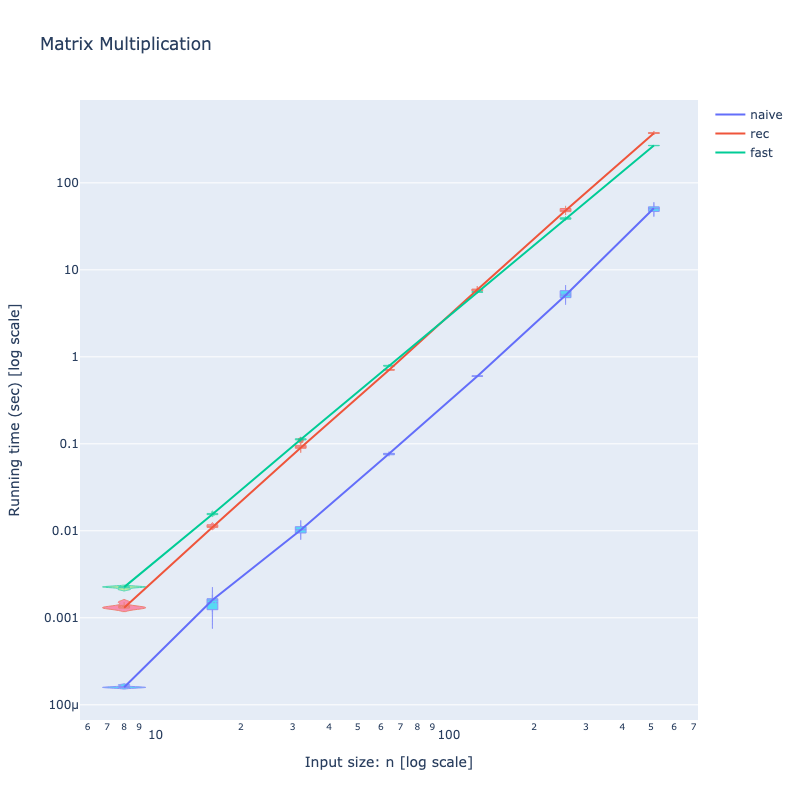

In [9]:
show_figure(rte.create_figure('Matrix Multiplication'), None if INTERACTIVE_CHARTS else 'img/04_2_Matrix.png')